<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
!pip install --upgrade scikit-learn -q
#базовые
import pandas as pd
import numpy as np
#генерация случайных чисел
import random
#учет времени выполнения
import time
# отключение ошибок
import warnings
# графики
import seaborn as sns
import matplotlib.pyplot as plt
# преобразование данных
from sklearn.model_selection import train_test_split, TimeSeriesSplit
# Модели
from sklearn.linear_model import LinearRegression, LogisticRegression
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
#проверка адекватности модели
from sklearn.dummy import DummyRegressor
# Метрики
from sklearn.metrics import root_mean_squared_error
# Инструменты подбора гиперпараметров
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
# пайплайны
from sklearn.pipeline import Pipeline
#временные ряды
from statsmodels.tsa.seasonal import seasonal_decompose

RANDOM_STATE = 88

In [2]:
#функция печати графиков для исследовательского анализа данных
def stat_plots(df, custom_bins={}, countplots=[]):
    for column in countplots:
        data = df[column]
        sns.countplot(data, palette='GnBu_r')
        plt.title(f'Количественный анализ дискретного признака {column}')
        plt.xlabel('Значения')
        plt.ylabel('Количество')
        plt.show()
    df = df.drop(countplots, axis=1)    
    for column in df.select_dtypes(include='number').columns:
        try:
            nbins = custom_bins[column]
        except:
            nbins = 10
        ind_label = df[column].name
        print('=' * 110)
        print(f'Статистический анализ показателя {ind_label}')
        print('-' * 110)
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
        bins = axes[0].hist(df[column], bins=nbins)
        axes[0].vlines(x=df[column].mean(), colors='red', ymin=0, ymax=bins[0].max(), label='Среднее')
        axes[0].vlines(x=df[column].median(), colors='red', ymin=0, ymax=bins[0].max(), linestyles='--', label='Медиана')
        axes[0].set_title('Гистограмма распределения')
        axes[0].set_xlabel(ind_label)
        axes[0].set_ylabel('Количество значений')
        axes[0].legend()
        axes[1].boxplot(df[column], vert=False)
        axes[1].set_title('Диаграмма размаха')
        axes[1].set_xlabel(ind_label)
        plt.show()
    for column in df.select_dtypes(include='object').columns:
        ind_label = df[column].name
        df[column].value_counts().plot(kind='pie', autopct='%.0f', subplots=True, legend=False, label=ind_label)
        plt.title(f'Распределение долей по показателю {ind_label}')
        plt.show()

Загрузим и изучим данные

In [3]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Пропусков в данных не обнаружено, выполним ресэмплинг до 1 часа

In [5]:
data = data.resample('1H').sum()

## Анализ

Изучим распределение данных

Статистический анализ показателя num_orders
--------------------------------------------------------------------------------------------------------------


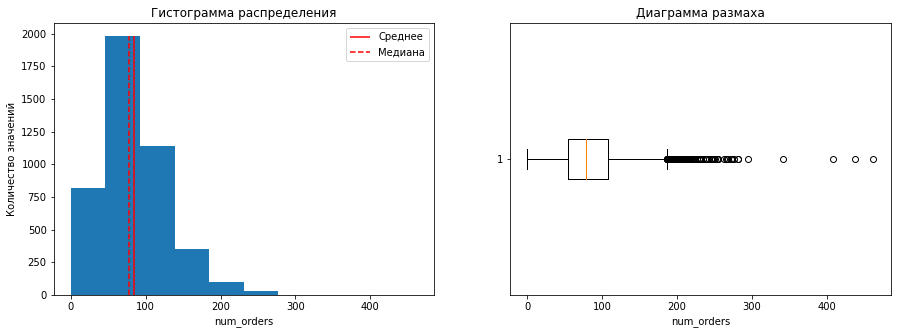

In [6]:
stat_plots(data)

Распределение данных ненормальное из-за выбросов.

Изучим исследуемый временной ряд на предмет стационарности

In [7]:
data['rolling_mean'] = data.num_orders.shift().rolling(24).mean()
data['rolling_mean'] = data['rolling_mean'].fillna(0).astype('int32')
data['std'] = data.num_orders.rolling(24).std()
data['std'] = data['std'].fillna(0).astype('int32')

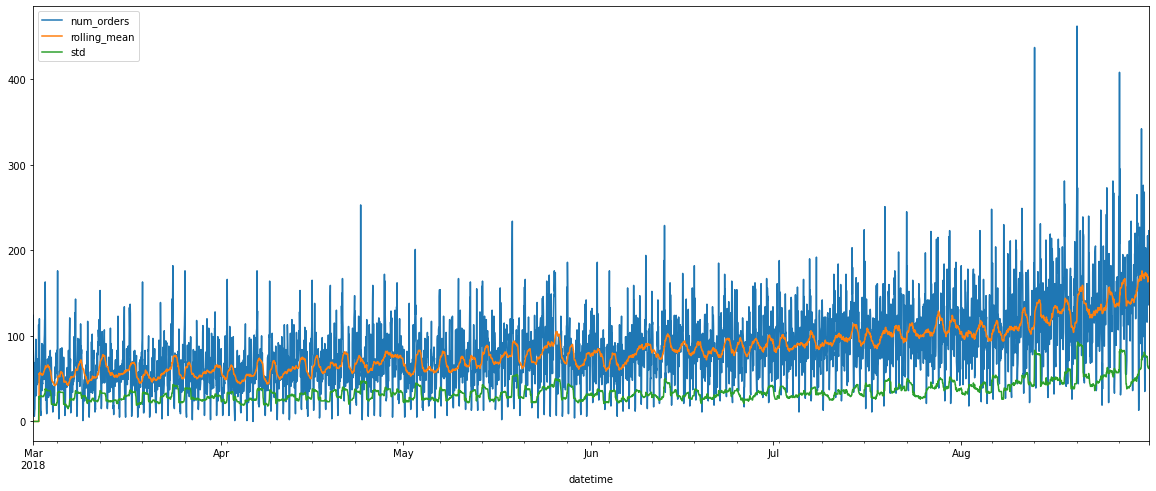

In [8]:
data.plot(figsize=(20, 8))
plt.show()

Как мы можем наблюдать на графике, исследуемый временной ряд не является стационарным, поскольку его скользящее среднее меняется.

In [9]:
# data.index = pd.DatetimeIndex(data.index).date

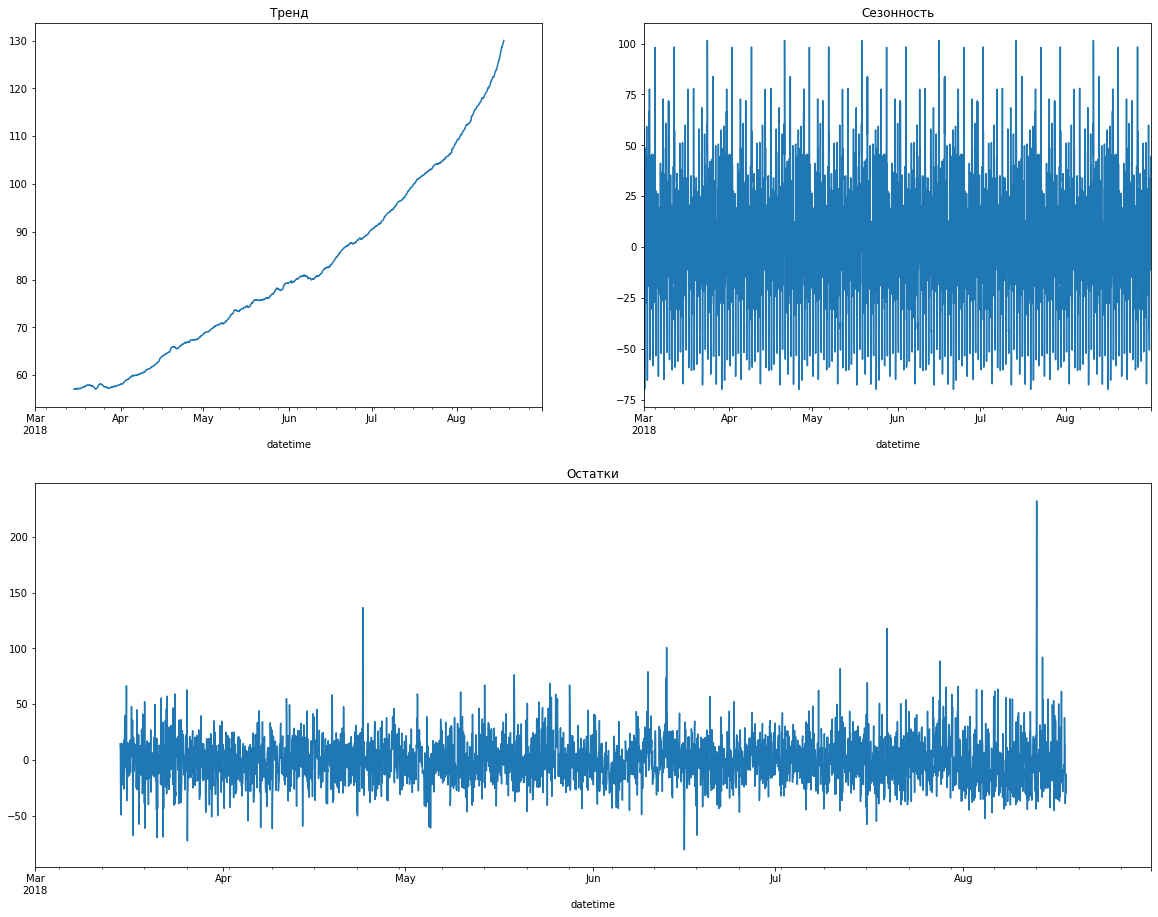

In [10]:
decomposed = seasonal_decompose(data.num_orders, period=168*4)

plt.figure(figsize=(20, 24))
plt.subplot(321)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(322)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(312)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.show()

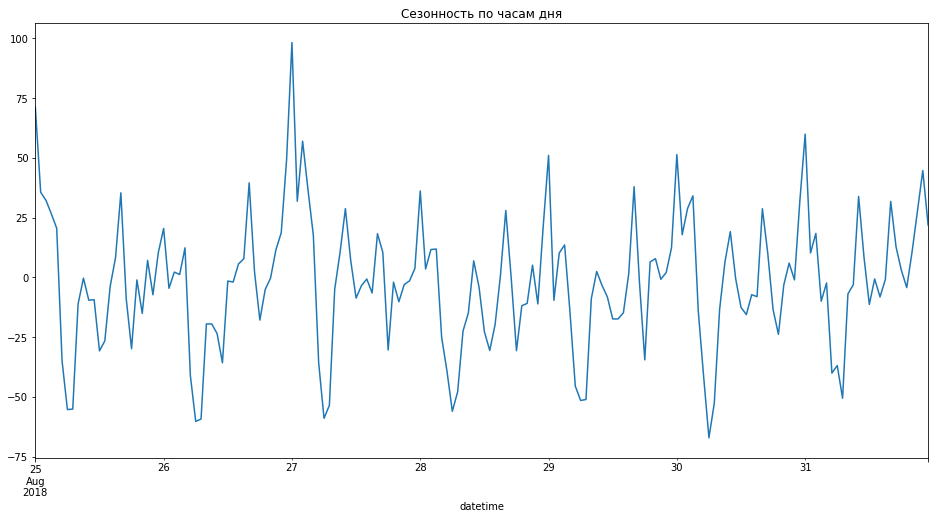

In [11]:
decomposed.seasonal.tail(24*7).plot(title='Сезонность по часам дня', figsize=(16, 8))
plt.show()

In [12]:
data_days = data.resample('1D').sum()

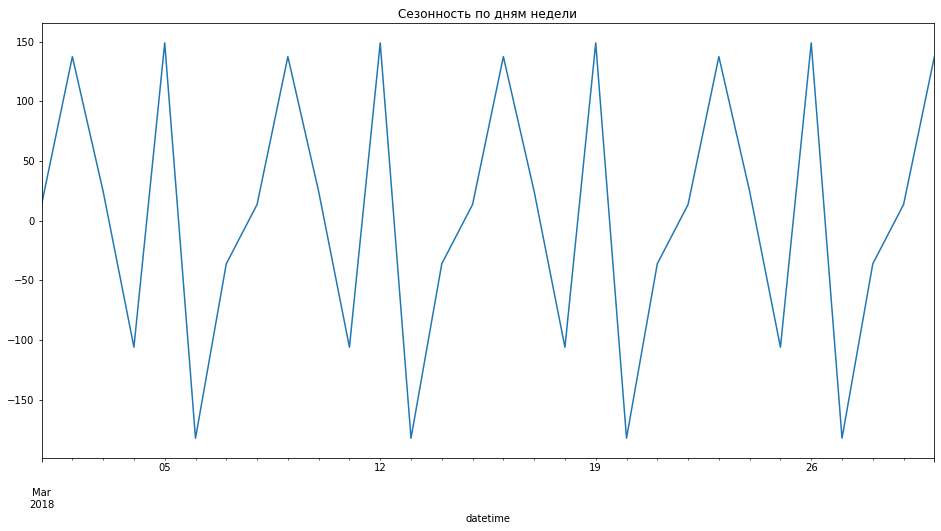

In [13]:
decomposed_daily = seasonal_decompose(data_days.num_orders)
decomposed_daily.seasonal.head(30).plot(title='Сезонность по дням недели', figsize=(16, 8))
plt.show()

Как мы можем наблюдать на графиках сезонности, имеется явная сезонность по часам в сутках, и по дням недели. Сезонность по дням месяца отсутствует, а для определения сезонности по месяцам и неделям у нас недостаточно данных.

## Обучение

Создадим функцию для добавления дополнительных вычисляемых признаков:

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data.num_orders.shift(lag)
    
    data['rolling_mean'] = data.num_orders.shift().rolling(rolling_mean_size).mean()

Создадим признаки при помощи этой функции и заполним пропуски

In [15]:
make_features(data, 7, 24)
data = data.fillna(0)
data

,num_orders,rolling_mean,std,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
datetime,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0.000000,0,1,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-03-01 01:00:00,85,0.000000,0,1,3,1,124.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-03-01 02:00:00,71,0.000000,0,1,3,2,85.0,124.0,0.0,0.0,0.0,0.0,0.0
2018-03-01 03:00:00,66,0.000000,0,1,3,3,71.0,85.0,124.0,0.0,0.0,0.0,0.0
2018-03-01 04:00:00,43,0.000000,0,1,3,4,66.0,71.0,85.0,124.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,164.875000,63,31,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0
2018-08-31 20:00:00,154,167.541667,63,31,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0
2018-08-31 21:00:00,159,168.041667,62,31,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0


Подготовим тренировочный датасет к обучению

In [16]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

In [17]:
X_train = train.drop('num_orders', axis=1)
y_train = train.num_orders

Составим пайплайны подбора модели и гиперпараметров

In [18]:
pipe_train =  Pipeline([
    ('models', 'passthrough')
])

In [19]:
param_grid = [   
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 15)
    },
    
    {
        'models': [LinearRegression()], 
        'models__n_jobs': range(2, 15)
    },
   
    {
        'models': [KNeighborsRegressor()], 
        'models__n_neighbors': range(5, 15)
    },
    
    {
       'models': [LGBMRegressor()]
    }
]

Инициализируем инструмент подбора параметров с кросс-валидацией

In [20]:
tscv = TimeSeriesSplit(n_splits=5)

param_search = GridSearchCV(
    pipe_train,
    param_grid,
    n_jobs=-1,
    cv=tscv,
    scoring='neg_root_mean_squared_error'
)

Выполним подбор гиперпараметров и определим наилучшую модель

In [21]:
warnings.filterwarnings('ignore')

param_search.fit(X_train, y_train)

pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(param_search.cv_results_)
result[['rank_test_score', 'params']].sort_values('rank_test_score').head(5)

,rank_test_score,params
192,1,{'models': LGBMRegressor()}
74,2,"{'models': DecisionTreeRegressor(random_state=88), 'models__max_depth': 7, 'models__max_features': 11}"
64,3,"{'models': DecisionTreeRegressor(random_state=88), 'models__max_depth': 6, 'models__max_features': 14}"
63,3,"{'models': DecisionTreeRegressor(random_state=88), 'models__max_depth': 6, 'models__max_features': 13}"
62,3,"{'models': DecisionTreeRegressor(random_state=88), 'models__max_depth': 6, 'models__max_features': 12}"


## Тестирование

Подготовим тестовый датасет

In [22]:
X_test = test.drop('num_orders', axis=1)
y_test = test.num_orders

Обучим лучшую модель по результатам подбора гиперпараметров и кросс-валидации

In [23]:
best_suite = param_search.best_estimator_
best_suite.fit(X_train, y_train)
y_pred = best_suite.predict(X_test)
rmse = int(root_mean_squared_error(y_test, y_pred))
print(f'Лучшая модель и ее параметры: {best_suite.named_steps["models"]}')
print(f'Ошибка RMSE лучшей модели на тестовых данных = {rmse}')

Лучшая модель и ее параметры: LGBMRegressor()
Ошибка RMSE лучшей модели на тестовых данных = 42


Целевая метрика выбранной модели находится в пределах диапазона согласно требованиям Заказчика.